In [1]:
import xgboost as xgb
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import pyarrow.feather as feather
from matplotlib import rcParams as rcParams
from atlasify import atlasify
from matplotlib import gridspec
import matplotlib as mlp
np.seterr(divide='ignore', invalid='ignore')
from sklearn import metrics
import json
import seaborn as sns

Loads data from arrow files, adds information like signal region, process, and whether the event is signal or not.

In [2]:
#dictionary to convert signal region numbers into words
srconvert={0:"SFinZ",1:"SFnoZ",2:"DF",-1:"CR"}
srs=["SFinZ","SFnoZ","DF"]
#variables used for training
variables = ['leptonic_HT', 'MET', 'Zlep1_dphi',
       'Wlep1_pt', 'total_HT', 'Zlep2_dphi', 'Zlep2_eta', 'Njet', 'Wlep2_eta',
       'Zlep2_pt', 'METSig', 'other_mass', 'Wlep1_dphi', 'Zlep1_pt',
       'mass_4l', 'pt_4l', 'Zlep1_eta', 'HT', 'Wlep1_eta',
       'Wlep2_dphi', 'Zcand_mass', 'Wlep2_pt','MET_dPhi']
#alternate variables proposed by michigan
#variables = ["leptonic_HT","HT","MET","METSig","pt_4l","Zlep1_dphi","Zlep1_eta","Zlep1_pt","Zlep2_dphi","Zlep2_eta",
#             "Zlep2_pt","Wlep1_dphi","Wlep1_eta","Wlep1_pt","Wlep2_dphi","Wlep2_eta","Wlep2_pt","Njet","other_mass",
#             "Zcand_mass","mass_4l","MET_dPhi","chisq","Wleps_deta","Wleps_dphi"]
#variables not used at all
excessVariables=["v_j_btag60",
                   "v_j_btag70", "v_j_btag77", 
                   "v_j_btag85", "v_j_btagCont",
                   "pt_1","pt_2","pt_3","pt_4",
                   "eta_1","eta_2","eta_3","eta_4",
                   "phi_1","phi_2","phi_3","phi_4",
                   "lep1_pid", "lep2_pid", 
                   "lep3_pid", "lep4_pid", "Nlep",
                   "Zlep1_pid", "Zlep2_pid", 
                   "Wlep1_pid", "Wlep2_pid",
                  "jet_pt_1", "jet_pt_2", "jet_pt_3", "jet_pt_4",
                   "jet_eta_1", "jet_eta_2", "jet_eta_3", "jet_eta_4",
                   "jet_phi_1", "jet_phi_2", "jet_phi_3", "jet_phi_4",
                   "jet_m_1", "jet_m_2", "jet_m_3", "jet_m_4",
                   "jet_btagCont_1", "jet_btagCont_2", "jet_btagCont_3", "jet_btagCont_4"]
#11 main processes
processes=["Signal", "ZZ", "Zjets", "Zgamma", "ttbar", "WZ", "tZ", "ttZ", "tWZ", "VBS", "VH", "Others"]
#signal subprocesses
sigprocesses=["Signal_WZZ_3l1v2j","Signal_ZZZ_4l2j", "Signal_WZZ_3l3v","Signal_ZZZ_4l2v","Signal_WWZ_2l4v","Signal_WZZ_4l2j","Signal_ZZZ_6l0v",
              "Signal_WWZ_3l1v2j","Signal_WZZ_5l1v","Signal_WWZ_4l2v","Signal_ZZZ_2l4v"]
#dictionaries to fill with events from processes and subprocessses
processDict={}
sigprocessDict={}
#path to files:
arrowLocation="/data/jiling/WVZ/v2.3-2023_01_16_arrow/"
for process in processes:
    print("Loading process: "+process)
    if process=="Signal": #if loading signal, instead load subprocesses
        for sigprocess in sigprocesses:
            #loads file from location of arrow files
            sigprocessDict[sigprocess]=pd.DataFrame(feather.read_feather(arrowLocation+sigprocess+".arrow"))
            print("\tLoaded data...")
            #adds collumn to dataframe to distinguish signal subprocesses
            sigprocessDict[sigprocess]["sigprocess"] = [sigprocess for x in range(len(sigprocessDict[sigprocess]))]
            #removes excess variables
            sigprocessDict[sigprocess]=sigprocessDict[sigprocess].drop(excessVariables,axis=1)
            sigprocessDict[sigprocess]["SR"] = [srconvert[x] for x in sigprocessDict[sigprocess].SR]
        processDict[process]=pd.concat(sigprocessDict.values())
        #creates is_signal variable to train with and process variable to distinguish processes
        processDict[process]["is_signal"] = [1 for x in range(len(processDict[process]))]
    else:
        processDict[process]=pd.DataFrame(feather.read_feather(arrowLocation+process+".arrow"))
        print("\tLoaded data...")
        processDict[process]["is_signal"] = [0 for x in range(len(processDict[process]))]
        processDict[process]=processDict[process].drop(excessVariables,axis=1)#removes excess variables
        processDict[process]["sigprocess"] = ["Background" for x in range(len(processDict[process]))]
        processDict[process]["SR"] = [srconvert[x] for x in processDict[process].SR]
    processDict[process]["process"] = [process for x in range(len(processDict[process]))]
#adds all processes together into one dataset
refined_data=pd.concat(processDict.values(),ignore_index=True)
#removed VH from training because VH is both signal and background
refined_data=refined_data[refined_data.process!="VH"]
refined_data=refined_data[refined_data.SR!="CR"]

Loading process: Signal
	Loaded data...
	Loaded data...
	Loaded data...
	Loaded data...
	Loaded data...
	Loaded data...
	Loaded data...
	Loaded data...
	Loaded data...
	Loaded data...
	Loaded data...
Loading process: ZZ
	Loaded data...
Loading process: Zjets
	Loaded data...
Loading process: Zgamma
	Loaded data...
Loading process: ttbar
	Loaded data...
Loading process: WZ
	Loaded data...
Loading process: tZ
	Loaded data...
Loading process: ttZ
	Loaded data...
Loading process: tWZ
	Loaded data...
Loading process: VBS
	Loaded data...
Loading process: VH
	Loaded data...
Loading process: Others
	Loaded data...


Splits data into 5 regions for k-folding

In [3]:
X_train={}
Y_train={}
X_test={}
Y_test={}
for i in range(5):
    X_train[i]=refined_data[np.mod(refined_data.event,5)!=i].drop("is_signal",axis=1)
    X_test[i]=refined_data[np.mod(refined_data.event,5)==i].drop("is_signal",axis=1)
    Y_train[i]=refined_data[np.mod(refined_data.event,5)!=i]["is_signal"]
    Y_test[i]=refined_data[np.mod(refined_data.event,5)==i]["is_signal"]

Creates XGBoost classifier with all default parameters except:
 - learning_rate=0.05
 - max_depth=8
 - colsample_bytree=0.8
 - 500 rounds

Creates 5 models for each signal region:

In [4]:
models={}
for sr in ["DF","SFnoZ","SFinZ"]:
    print("on sr "+sr)
    models[sr]={}
    for i in range(5):
        print("on model",str(i))
        models[sr][i]=xgb.XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
                          colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
                          early_stopping_rounds=20, enable_categorical=False,
                          eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
                          importance_type=None, interaction_constraints='',
                          learning_rate=0.05, max_bin=256, max_cat_to_onehot=4,
                          max_delta_step=0, max_depth=8, max_leaves=0, min_child_weight=1,
                          monotone_constraints='()', n_estimators=500,
                          n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
                          reg_alpha=0, reg_lambda=1)
        models[sr][i].fit(X_train[i][X_train[i].SR==sr][variables], Y_train[i][X_train[i].SR==sr], 
                            eval_set=[(X_train[i][X_train[i].SR==sr][variables],
                                    Y_train[i][X_train[i].SR==sr]), (X_test[i][X_test[i].SR==sr][variables], Y_test[i][X_test[i].SR==sr])],verbose=0)
        models[sr][i].save_model("../../../data/rjacobse/WVZ/"+sr+str(i)+".model")

on sr DF
on model 0
on model 1
on model 2
on model 3
on model 4
on sr SFnoZ
on model 0
on model 1
on model 2
on model 3
on model 4
on sr SFinZ
on model 0
on model 1
on model 2
on model 3
on model 4


Loads 5 models for each signal region:

In [4]:
models={}
for sr in ["SFinZ","SFnoZ","DF"]:
    models[sr]={}
    for i in range(5):
        models[sr][i]=xgb.XGBClassifier()
        models[sr][i].load_model("/data/rjacobse/WVZ/"+sr+str(i)+".model")

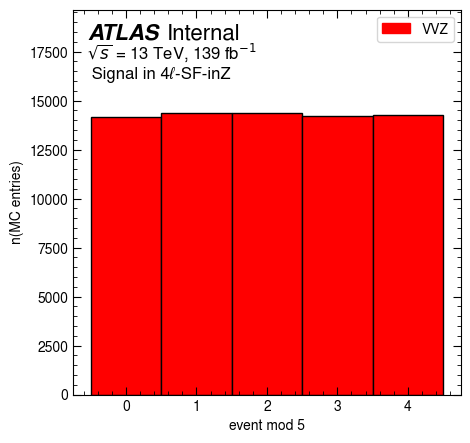

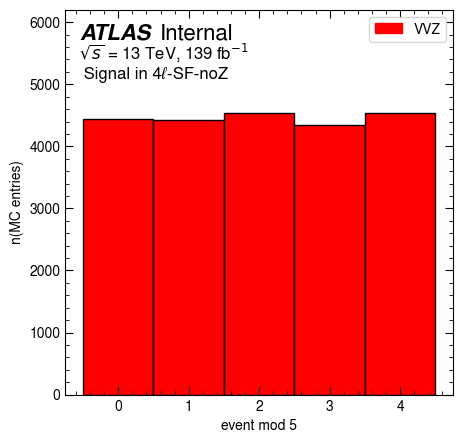

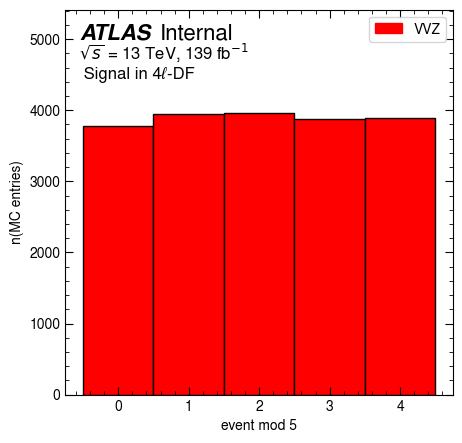

In [5]:
srfull={"SFinZ":"4ℓ-SF-inZ","SFnoZ":"4ℓ-SF-noZ","DF":"4ℓ-DF"}
for sr in srs:
    plt.figure(figsize=(5,5))
    plt.ylabel("n(MC entries)")
    plt.xlabel("event mod 5")
    plt.xticks([0.5,1.5,2.5,3.5,4.5],[0,1,2,3,4])
    bins=[0,1,2,3,4,5]
    sighist=plt.hist(np.mod(refined_data.event[(refined_data.is_signal==1) & (refined_data.SR==sr)],5),edgecolor="black", linewidth=1,
                             #weights=refined_data.wgt[(refined_data.is_signal==1) & (refined_data.SR==sr)],
                             bins=bins,color="red",zorder=0)
    atlasify('Internal', '$\sqrt{s}$ = 13 TeV, 139 fb$^{-1}$\n Signal in '+srfull[sr],outside=False)
    plt.legend([plt.Rectangle((0,0),1,1, color="red")], ["VVZ"],bbox_to_anchor=(1, 1))
    plt.savefig("bdtgraphs/"+sr+"signalmod5.pdf", format="pdf", bbox_inches="tight")

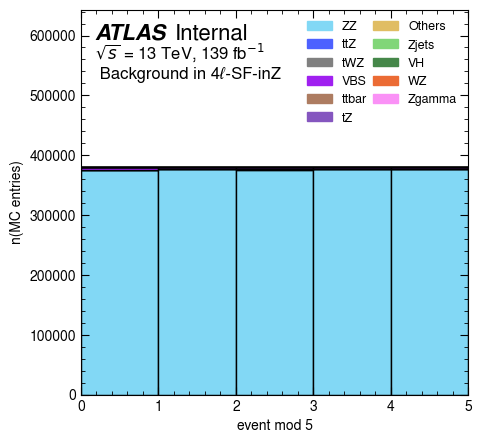

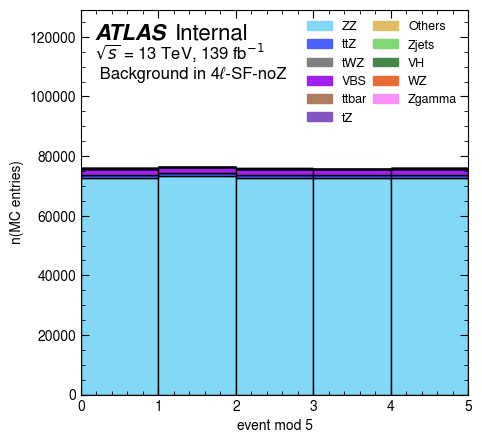

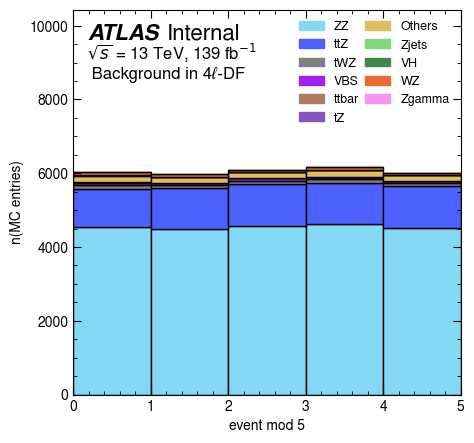

In [6]:
processes=["ZZ","ttZ","tWZ","VBS","ttbar","tZ","Others","Zjets","VH","WZ","Zgamma","Signal"]
srfull={"SFinZ":"4ℓ-SF-inZ","SFnoZ":"4ℓ-SF-noZ","DF":"4ℓ-DF"}
colors={"ZZ":"#82D8F5",
        "ttZ":"#4D61FF",
        "tWZ":"#808080",
        "VBS":"#A020F0",
        "ttbar":"#AD7C61",
        "tZ":"#8556BF",
        "Others":"#E0BD63",
        "Zjets":"#81D678",
        "VH":"#458749",
        "WZ":"#EB6B34",
        "Zgamma":"#FA91F6"}
bins=[0,1,2,3,4,5]
for sr in srs:
    xmin=0
    xmax=5
    plt.figure(figsize=(5,5))
    tostack=[]
    tostackbins=[]
    for process in processes[:-1]:
        tostackbins.append(bins[:-1])
        tostack.append(np.histogram(np.mod(refined_data.event[(refined_data.process==process) & (refined_data.SR==sr)],5),bins=bins)[0])
    combinedbins=np.stack(tostackbins)
    combinedhists=np.stack(tostack)
    barwidth=(bins[1]-bins[0])
    plt.hist(np.transpose(combinedbins),weights=np.transpose(combinedhists),stacked=True,bins=bins,color=list(colors.values()),edgecolor="black", linewidth=1)
    plt.ylabel("n(MC entries)")
    plt.xlabel("event mod 5")
    plt.xlim(xmin,xmax)
    plt.ylim(0,1.3*np.max(np.sum(np.transpose(combinedhists),axis=1)))
    handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in list(colors.keys())]
    plt.legend(handles, list(colors.keys()),loc=1,ncols=2,columnspacing=0.5,fontsize=9)
    atlasify('Internal', '$\sqrt{s}$ = 13 TeV, 139 fb$^{-1}$\n Background in '+srfull[sr],outside=False)
    plt.savefig("bdtgraphs/"+sr+"backgroundmod5.pdf", format="pdf", bbox_inches="tight");
    plt.show()

Loss graph for each round:

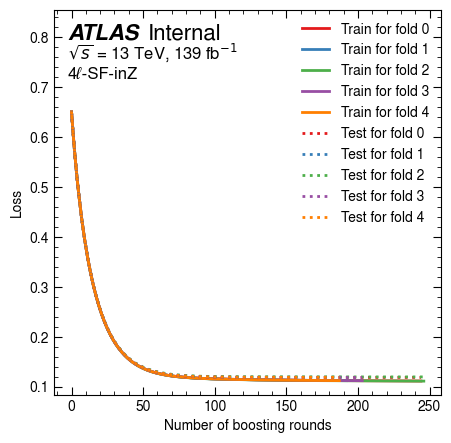

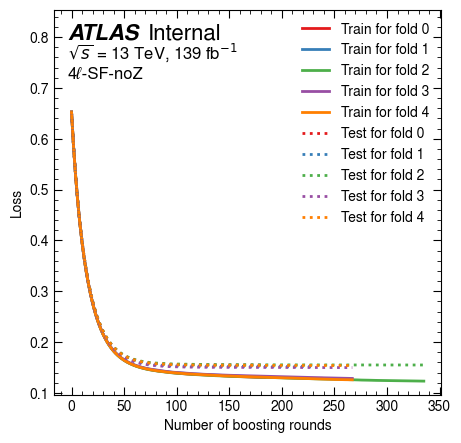

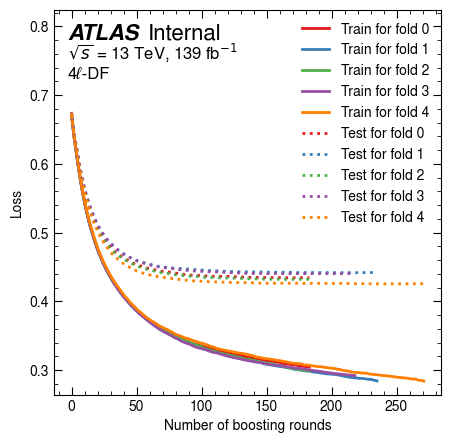

In [7]:
theme="Set1"

for sr in srs:
    plt.figure(figsize=(5,5))
    for i in range(5):
        results = models[sr][i].evals_result()
        plt.plot(results["validation_0"]["logloss"], label="Train for fold "+ str(i),color=mlp.colormaps[theme](i),linewidth=2)
    
    for i in range(5):
        results = models[sr][i].evals_result()
        plt.plot(results["validation_1"]["logloss"], label="Test for fold " +str(i),linestyle="dotted",color=mlp.colormaps[theme](i),linewidth=2)
    plt.legend(loc=1,ncols=1)
    plt.xlabel("Number of boosting rounds")
    plt.ylabel("Loss")
    atlasify('Internal', '$\sqrt{s}$ = 13 TeV, 139 fb$^{-1}$\n'+srfull[sr],outside=False)
    plt.savefig("bdtgraphs/loss"+sr+".pdf", format="pdf", bbox_inches="tight")
    plt.show()

ROC curves for each model in each signal region:

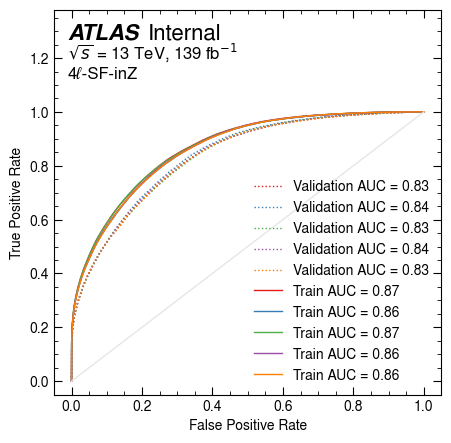

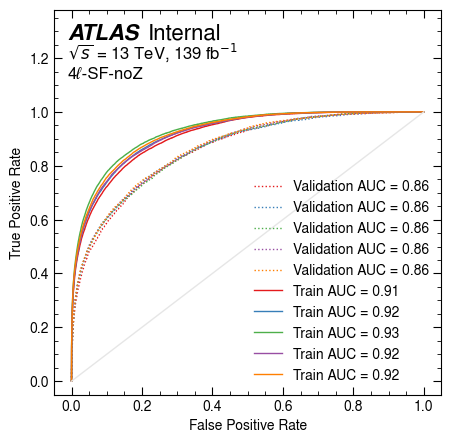

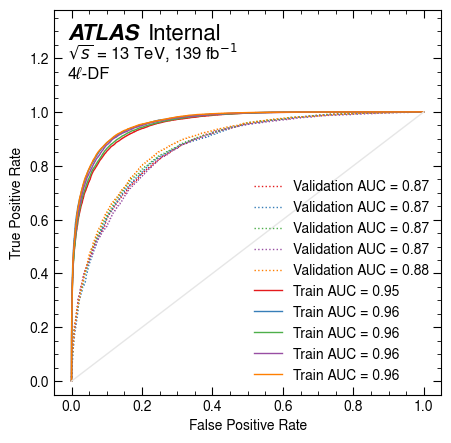

In [8]:
theme="Set1"
aucs={}
for sr in srs:
    aucs[sr]=[]
    plt.figure(figsize=(5,5))
    for i in range(5):
        fpr, tpr, threshold = metrics.roc_curve(list(Y_test[i][X_test[i]["SR"]==sr]),list(models[sr][i].predict_proba(X_test[i][X_test[i]["SR"]==sr][variables])[:,1]))
        roc_auc = metrics.auc(fpr, tpr)
        aucs[sr].append(roc_auc)
        plt.plot(fpr, tpr, label = 'Validation AUC = %0.2f' % roc_auc,color=mlp.colormaps[theme](i),linewidth=1,linestyle="dotted")
    for i in range(5):
        fpr, tpr, threshold = metrics.roc_curve(list(Y_train[i][X_train[i]["SR"]==sr]),list(models[sr][i].predict_proba(X_train[i][X_train[i]["SR"]==sr][variables])[:,1]))
        roc_auc = metrics.auc(fpr, tpr)
        plt.plot(fpr, tpr, label = 'Train AUC = %0.2f' % roc_auc,color=mlp.colormaps[theme](i),linewidth=1)


    plt.legend()
    plt.plot([0, 1], [0, 1],color=(0.9,0.9,0.9),linewidth=1)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')        
    atlasify('Internal', '$\sqrt{s}$ = 13 TeV, 139 fb$^{-1}$\n'+srfull[sr],outside=False)
    plt.savefig("bdtgraphs/AUC"+sr+".pdf", format="pdf", bbox_inches="tight")
    plt.show()

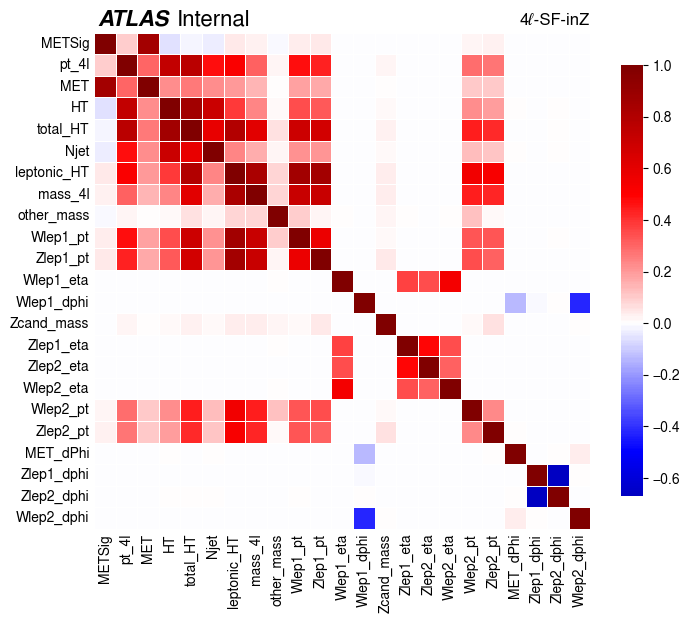

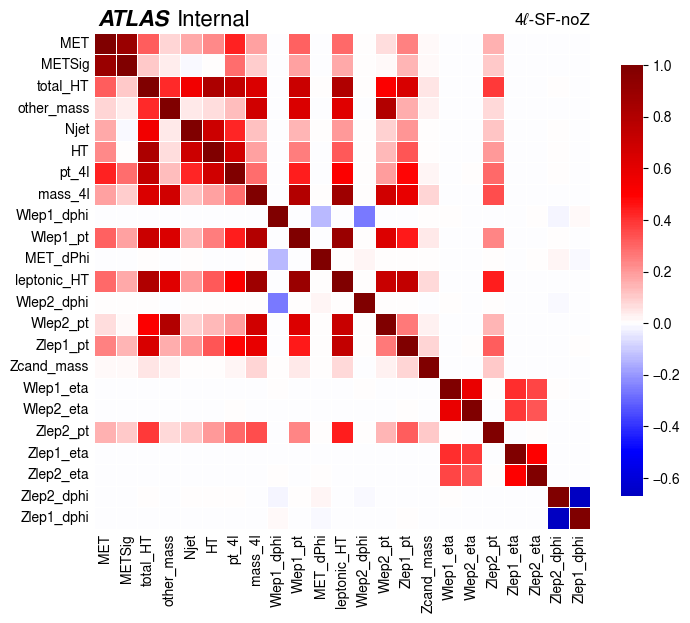

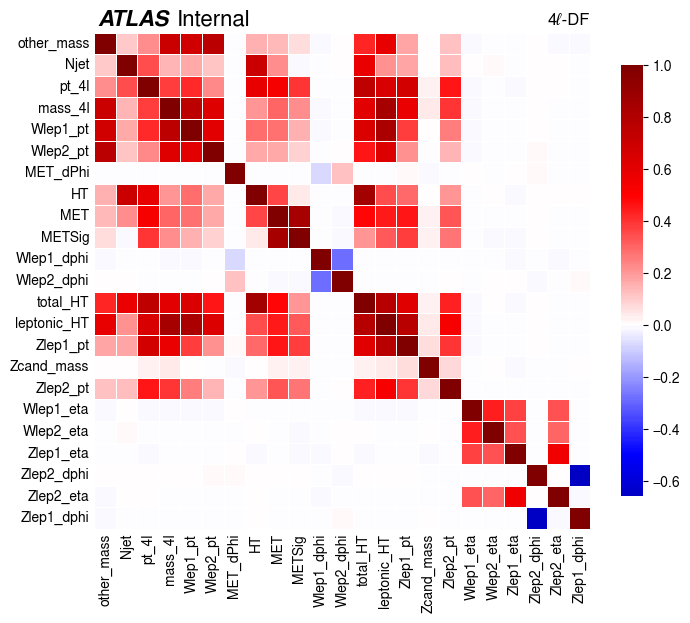

In [9]:
def correlation_heatmap(train,sr):
    correlations = train.corr()

    fig, ax = plt.subplots(figsize=(8,8))
    sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f', cmap="seismic",
                square=True, linewidths=.5, annot=False, cbar_kws={"shrink": .70}
                )
    atlasify('Internal', outside=True)
    plt.tick_params(
        which='both',      
        bottom=False,    
        top=False,          
        left=False,    
        right=False,  
        labelbottom=True)
    plt.title(srfull[sr],loc="right")
    plt.savefig("bdtgraphs/heatmap"+sr+".pdf", format="pdf", bbox_inches="tight")
    plt.show();
for sr in srs:
    sorted_idx = np.flip(np.mean([models[sr][0].feature_importances_,models[sr][1].feature_importances_,models[sr][2].feature_importances_,models[sr][3].feature_importances_,models[sr][4].feature_importances_],axis=0).argsort())
    correlation_heatmap(refined_data[refined_data.SR==sr][np.asarray(variables)[sorted_idx]],sr)

All functions used in the code are defined below:

In [10]:
#creates a numpy histogram out of bdt outputs with n bins and a range from (0,1)
def createhist(selectedevents,nbins,cut=0,uppercut=1,weighted=True):
    data=selectedevents[0]
    weight=selectedevents[1]
    if weighted:
        counts,bins=np.histogram(data,bins=nbins,range=(cut,uppercut),weights=weight)
        sumw2,bins=np.histogram(data,bins=nbins,range=(cut,uppercut),weights=weight**2)
        return(counts,bins,sumw2)
    else:
        counts,bins=np.histogram(data,bins=nbins,range=(cut,uppercut))
        return(counts,bins)

#takes a subset of events and returns their bdt predictions
def selectevents(data,funcmodel,region=None,signal=False,background=False,sr=None,process=None,sigprocess=None,highweight=None,train=False,nrounds=100):
    reduced_data=data
    #select events with given attributes
    if region != None: reduced_data=reduced_data[np.mod(reduced_data["event"],5)==region]
    if highweight != None: reduced_data=reduced_data[reduced_data["wgt"]<highweight]
    if signal: reduced_data=reduced_data[reduced_data["is_signal"]==1]
    if background: reduced_data=reduced_data[reduced_data["is_signal"]==0]
    if process != None: reduced_data=reduced_data[reduced_data["process"]==process]
    if sigprocess != None: reduced_data=reduced_data[reduced_data["sigprocess"]==sigprocess]
    #if there aren't any events left, just return empty arrays
    if len(reduced_data) == 0:
        return(np.array([]),np.array([]))
    #if signal region is not specified
    if sr == None:
        outputs={}
        #runs model for each signal reigon
        for sr in ["SFinZ","SFnoZ","DF"]:
            #if the length is zero, return empty array for that signal region
            if len(reduced_data[reduced_data["SR"]==sr][variables])==0:
                outputs[sr]=np.array([])
            else:
                #if the region is specified
                if region != None:
                    #output for the signal region is evaluated
                    if train: #evaluate on model that it was trained on
                        outputs[sr]=funcmodel[sr][np.mod(region+1,5)].predict_proba(reduced_data[reduced_data["SR"]==sr][variables],iteration_range=(0,nrounds))[:,1]
                    else: #evaluate on model that it wasn't trained on
                        outputs[sr]=funcmodel[sr][region].predict_proba(reduced_data[reduced_data["SR"]==sr][variables],iteration_range=(0,nrounds))[:,1]
                #if the region is not specified
                else:
                    returns=np.asarray([])
                    for i in range(5): #for each region
                        #only evalute on MC from that region
                        toeval=reduced_data[np.mod(reduced_data["event"],5)==i]
                        if train:
                            returns=np.append(returns,funcmodel[sr][np.mod(i+1,5)].predict_proba(toeval[toeval["SR"]==sr][variables],iteration_range=(0,nrounds))[:,1])
                        else:
                            returns=np.append(returns,funcmodel[sr][i].predict_proba(toeval[toeval["SR"]==sr][variables],iteration_range=(0,nrounds))[:,1])
                    outputs[sr]=returns
        return(np.concatenate((outputs["SFinZ"],outputs["SFnoZ"],outputs["DF"])),reduced_data["wgt"])
    #if signal region is specified
    else:
        #if the full model dict was passed, only take the models for the signal region chosen
        if type(funcmodel)==dict and "SFinZ" in funcmodel: funcmodel=funcmodel[sr]
        #restricts to events with that signal region
        reduced_data=reduced_data[reduced_data["SR"]==sr]
        #if the region is not specified
        if region == None:
            returns=np.asarray([])
            for i in range(5):
                toeval=reduced_data[np.mod(reduced_data["event"],5)==i]
                if train:
                    returns=np.append(returns,funcmodel[np.mod(i+1,5)].predict_proba(toeval[variables],iteration_range=(0,nrounds))[:,1])
                else:
                    returns=np.append(returns,funcmodel[i].predict_proba(toeval[variables],iteration_range=(0,nrounds))[:,1])
            return(returns,reduced_data["wgt"])
        #if the region is specified
        else:
            if train:
                return(funcmodel[np.mod(region+1,5)].predict_proba(reduced_data[variables])[:,1],reduced_data["wgt"])
            else:
                return(funcmodel[region].predict_proba(reduced_data[variables],iteration_range=(0,nrounds))[:,1],reduced_data["wgt"])


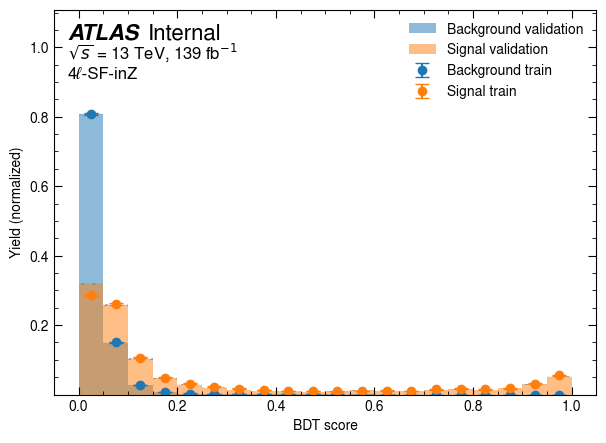

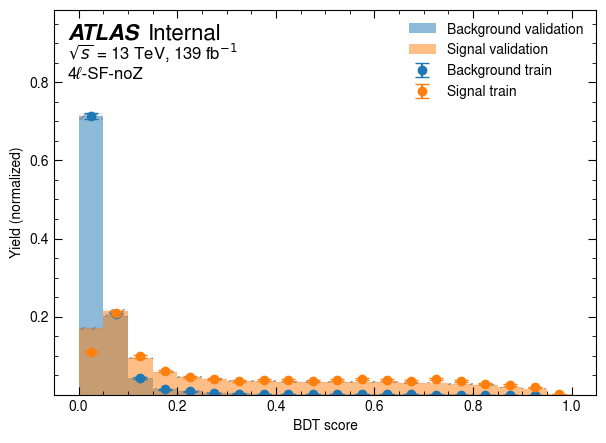

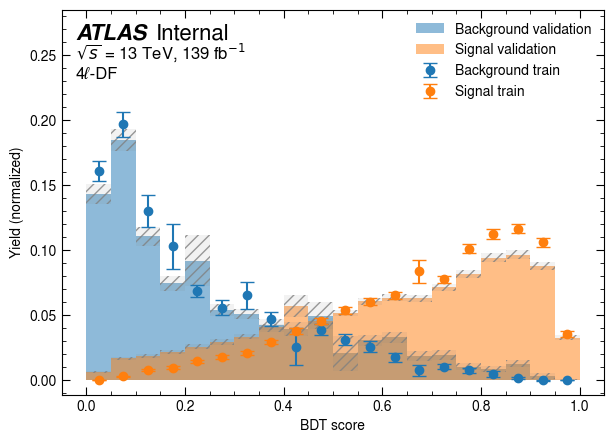

KeyError: None

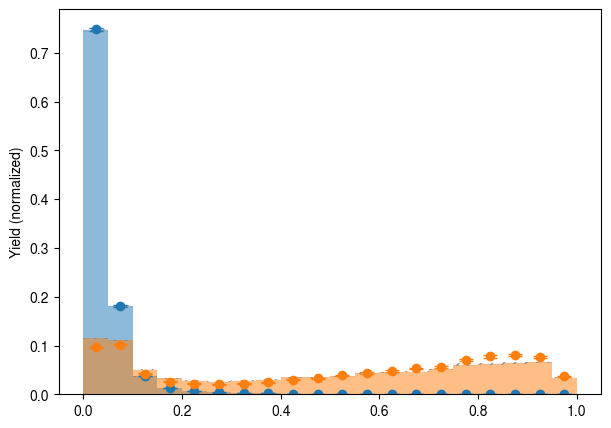

In [11]:
xmin=-0.05
xmax=1.05
nbins=20
n=0.025
for sr in ["SFinZ","SFnoZ","DF",None]:
    plt.figure(figsize=[7,5])
    rcParams["hatch.color"]=(0.5,0.5,0.5,0.8)
    plt.xlim(xmin,xmax)
    bg_train_hist,bins,bg_train_sumw2=createhist(selectevents(refined_data,background=True,funcmodel=models,sr=sr,highweight=None,train=True,region=None),nbins)
    sig_train_hist,bins,sig_train_sumw2=createhist(selectevents(refined_data,signal=True,funcmodel=models,sr=sr,highweight=None,train=True,region=None),nbins)
    bg_val_hist,bins,bg_val_sumw2=createhist(selectevents(refined_data,background=True,funcmodel=models,sr=sr,highweight=None,region=None),nbins)
    sig_val_hist,bins,sig_val_sumw2=createhist(selectevents(refined_data,signal=True,funcmodel=models,sr=sr,highweight=None,region=None),nbins)

    plt.hist((bins + n)[:-1],bins,weights=bg_val_hist/sum(bg_val_hist), range=(0,1),alpha=0.5, label='Background validation')
    plt.hist((bins + n)[:-1],bins,weights=sig_val_hist/sum(sig_val_hist), range=(0,1),alpha=0.5, label='Signal validation')
    plt.ylabel("Yield (normalized)")
    bg_val_error=np.sqrt(bg_val_sumw2)/sum(bg_val_hist)
    sig_val_error=np.sqrt(sig_val_sumw2)/sum(sig_val_hist)
    
    plt.errorbar((bins + n)[:-1],bg_train_hist/sum(bg_train_hist),yerr=np.sqrt(bg_train_sumw2)/sum(bg_train_hist), fmt="o", label='Background train',color='#1f77b4',capsize=5)
    plt.errorbar((bins + n)[:-1],sig_train_hist/sum(sig_train_hist),yerr=np.sqrt(sig_train_sumw2)/sum(sig_train_hist), fmt="o", label='Signal train',color='#ff7f0e',capsize=5)
    plt.bar((bins + n)[:-1], 2*bg_val_error, bottom=bg_val_hist/sum(bg_val_hist)-bg_val_error, width=0.05,hatch='///',color=(0.5, 0.5, 0.5,0.1))
    plt.bar((bins + n)[:-1], 2*sig_val_error, bottom=sig_val_hist/sum(sig_val_hist)-sig_val_error, width=0.05,hatch='///',color=(0.5, 0.5, 0.5,0.1))

    regiontext=""
    plt.xlim(xmin,xmax)

    atlasify('Internal', '$\sqrt{s}$ = 13 TeV, 139 fb$^{-1}$\n'+srfull[sr],outside=False)
    plt.savefig("bdtgraphs/BDTdistribution"+sr+".pdf", format="pdf", bbox_inches="tight")
    plt.xlabel("BDT score")
    plt.show()